In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import re
import nltk
import spacy
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from spacy.language import Language
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from ipywidgets import Dropdown, interactive
from sklearn.linear_model import LinearRegression


/Users/jesidacosta/.local/share/virtualenvs/ISM6930-CY7GBNHA/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Download the file BookingDotCom_HotelReviews.xlsx from Canvas. This file contains over 515,000 guest reviews and rating of almost 1500 hotels across Europe scraped from popular hotel reservation website Booking.com. The text data was cleaned by removing unicode and punctuation and transformed to lower case. No other preprocessing was done. More information on each field is provided in the "Data Description" tab of the Excel file.

Extending the analysis of this data set from class, you are asked to answer the following questions:

1. What are the top hotel features that guests talk about the most in their Booking.com reviews? Since this is a copy-and-paste from class handout, no points are assigned for this question. (0 point)

2. Score each guest review along each of the above features. Note that features that are not mentioned in a given review should receive no score for that review. You may use the approach discussed in class or a different approach of your choice. (4 points)

3. Compute the average feature score for each review, and report the correlation between this average score and the “Reviewer_Score” column in the data file. A strong positive correlation (>0.70) would indicate that your scoring mechanism worked. If your correlation was not up to the mark, you may want to explore what you can do to improve it.(1 point)

4. Compute average feature-wise score for each hotel (across all reviews) and report the correlation between these computed hotel scores and Average_Hotel_Score. (1 point).

5. Create a dashboard with the following plots: (1) Ten highest rated hotels in Europe (showing your aggregate score and Average_Hotel_Score), (2) Ten highest rated hotels for each of the top five features identified in Question 1. (2 points).

6. Regress Average_Hotel_Score against the top five feature scores of each hotel, and provide quantitative estimates of how important each feature is for the Average_Hotel_Score. (2 points)
Write clear, compact, and understandable code with comment/markdown statements as appropriate. Non-working code or unnecessary code will be penalized. (2 points)

Submit your Jupyter file using the link below.

In [4]:
# Setting Path to read data
PATH = pathlib.Path(os.getcwd()).joinpath('..','Module4', 'BookingDotCom_HotelReviews.xlsx')
# Reading Data
df = pd.read_excel(PATH)

# Attempts to improve Q1

In [2]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
# from spacy.language import Language

nlp.remove_pipe('custom_sentence_stop')

@Language.component('custom_sentence_stop')
def add_custom_sentence_stop(doc):
    for token in doc[:-1]:
        if token.is_title and (token.text != 'I' and token.pos_ !='PRON'):
            doc[token.i].is_sent_start = True
            # print(token, 'is new sent start')
    return doc

nlp.add_pipe('custom_sentence_stop', before='parser')

In [235]:
review = df.loc[40, 'Positive_Review']

doc = nlp(review)
doc

 The hotel is nicely localted directly within the park which is accessed when walking out of the building The building itself has great history and wonderful architecture The staff is very helpful and friendly when in need of anything 

In [236]:
# doc = nlp("Friendly staff. OostPark a few yards away. Good continental breakfast selection. Quiet and relaxing area")

In [237]:
# for i ,chunk in enumerate(doc.noun_chunks):
#     print(f'{i}:', [(w.text, w.pos_, w.dep_) for w in chunk])

In [238]:
for sent in doc.sents:
    print('--- New Sentence --')
    for token in sent:
        print(token, token.pos_, token.dep_, spacy.explain(token.pos_), spacy.explain(token.dep_))
        # if token.text == 'hotel':
        #     print(token.head.head.head, '-->', token)

--- New Sentence --
  SPACE ROOT space None
--- New Sentence --
The DET det determiner determiner
hotel NOUN nsubjpass noun nominal subject (passive)
is AUX auxpass auxiliary auxiliary (passive)
nicely ADV advmod adverb adverbial modifier
localted VERB ROOT verb None
directly ADV advmod adverb adverbial modifier
within ADP prep adposition prepositional modifier
the DET det determiner determiner
park NOUN pobj noun object of preposition
which DET nsubjpass determiner nominal subject (passive)
is AUX auxpass auxiliary auxiliary (passive)
accessed VERB relcl verb relative clause modifier
when ADV advmod adverb adverbial modifier
walking VERB advcl verb adverbial clause modifier
out SCONJ prep subordinating conjunction prepositional modifier
of ADP prep adposition prepositional modifier
the DET det determiner determiner
building NOUN pobj noun object of preposition
--- New Sentence --
The DET det determiner determiner
building NOUN nsubj noun nominal subject
itself PRON appos pronoun appos

In [211]:
for sent in doc.sents:
    print('--New Sent--')
    for word in sent:
            if word.pos_ == 'NOUN': #and word.dep_ == 'compound':
                print(word,':',[(w.text, w.pos_, w.dep_) for w in doc[i-2:i+4]])
                # print((word.text, word.pos_, word.dep_), (word.nbor().text,word.nbor().pos_, word.nbor().dep_))
                print(word.text)
                print('\t Lefts:', list(word.lefts))
                print('\t Rights:', list(word.rights))
                print('\t Ancestors:', list(word.ancestors))
                # print('\t nbor:', word.nbor(1).pos_)

--New Sent--
--New Sent--
restaurant : [('with', 'ADP', 'prep'), ('modern', 'ADJ', 'amod'), ('design', 'NOUN', 'pobj'), ('great', 'ADJ', 'amod'), ('chill', 'NOUN', 'appos'), ('out', 'ADP', 'advmod')]
restaurant
	 Lefts: [Good]
	 Rights: [with, chill, place]
	 Ancestors: []
design : [('with', 'ADP', 'prep'), ('modern', 'ADJ', 'amod'), ('design', 'NOUN', 'pobj'), ('great', 'ADJ', 'amod'), ('chill', 'NOUN', 'appos'), ('out', 'ADP', 'advmod')]
design
	 Lefts: [modern]
	 Rights: []
	 Ancestors: [with, restaurant]
chill : [('with', 'ADP', 'prep'), ('modern', 'ADJ', 'amod'), ('design', 'NOUN', 'pobj'), ('great', 'ADJ', 'amod'), ('chill', 'NOUN', 'appos'), ('out', 'ADP', 'advmod')]
chill
	 Lefts: [great]
	 Rights: [out]
	 Ancestors: [restaurant]
place : [('with', 'ADP', 'prep'), ('modern', 'ADJ', 'amod'), ('design', 'NOUN', 'pobj'), ('great', 'ADJ', 'amod'), ('chill', 'NOUN', 'appos'), ('out', 'ADP', 'advmod')]
place
	 Lefts: []
	 Rights: []
	 Ancestors: [restaurant]
--New Sent--
park : [('wit

In [228]:
nlp.pipe_names

['tok2vec',
 'tagger',
 'custom_sentence_stop',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner']

In [213]:
for chunk in doc.noun_chunks:
    print('----- New Chunck -----')
    for word in chunk:
        if word.pos_ == 'NOUN':
            print(word.text)
            print('\t Lefts:', list(word.lefts))
            print('\t Rights:', list(word.rights))
        #     print(word.text, word.pos_, word.dep_, '<--', list(word.children))
        #     print('\t', [(w, w.pos_, [w.text for w in list(w.children) if w.pos_ == 'ADJ'] )for w in list(word.ancestors) if w.pos_ =='AUX'])
        # # print(word.text, word.pos_, word.dep_, '-->',word.head, '-->', word.head.head )
    # print(chunk.text, chunk.root.dep_, spacy.explain(chunk.root.dep_), chunk.root.text, chunk.root.pos_, chunk.root.head.text)

----- New Chunck -----
restaurant
	 Lefts: [Good]
	 Rights: [with, chill, place]
----- New Chunck -----
design
	 Lefts: [modern]
	 Rights: []
----- New Chunck -----
chill
	 Lefts: [great]
	 Rights: [out]
----- New Chunck -----
place
	 Lefts: []
	 Rights: []
----- New Chunck -----
park
	 Lefts: [Great]
	 Rights: [nearby]
----- New Chunck -----
hotel
	 Lefts: [the]
	 Rights: [and, stairs]
----- New Chunck -----
stairs
	 Lefts: [awesome, main]
	 Rights: []


In [72]:
for ent in doc.ents:
    print(ent.text,)

# Questions

## 1. What are the top hotel features that guests talk about the most in their Booking.com reviews? Since this is a copy-and-paste from class handout, no points are assigned for this question. (0 point)


In [2]:
nlp = spacy.load('en_core_web_sm')

if 'custom_sentence_stop' in nlp.pipe_names:
    nlp.remove_pipe('custom_sentence_stop')

@Language.component('custom_sentence_stop')
def add_custom_sentence_stop(doc):
    for token in doc[:-1]:
        if token.is_title and (token.text != 'I' and token.pos_ !='PRON'):
            doc[token.i].is_sent_start = True
            # print(token, 'is new sent start')
    return doc

nlp.add_pipe('custom_sentence_stop', before='parser')
nlp.pipe_names

['tok2vec',
 'tagger',
 'custom_sentence_stop',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner']

In [261]:
review = df.loc[40, 'Positive_Review']

doc = nlp(review)
doc

 The hotel is nicely localted directly within the park which is accessed when walking out of the building The building itself has great history and wonderful architecture The staff is very helpful and friendly when in need of anything 

In [282]:
for num in list(range(10))[:4]:
    review = df.loc[num, 'Positive_Review']
    print('-- NEW DOC -- ')
    doc = nlp(review)
    doc
    for sent in doc.sents:
        print('--- New Sentence --')
        print(sent)
        for token in sent:
            if token.pos_ == 'NOUN':  # and token.dep_ in ["nsubj", "nsubjpass", "ROOT"]:
                if token.dep_ in ["nsubj", "nsubjpass"]:
                    print(token, token.dep_)
                    print('\t',[(w.text, w.pos_) for w in sent[token.i:token.i+4]])
                if token.dep_ == 'ROOT':
                    tmp_tok = token.nbor(-1)
                    print(token, token.dep_)
                    print('\t',tmp_tok, tmp_tok.pos_, tmp_tok.dep_, spacy.explain(tmp_tok.pos_), spacy.explain(tmp_tok.dep_))
            # if token.text == 'hotel':
            #     print(token.head.head.head, '-->', token)
    print('\n')

-- NEW DOC -- 
--- New Sentence --
 
--- New Sentence --
Only the park outside of the hotel was beautiful
park nsubj
	 [('outside', 'ADV'), ('of', 'ADP'), ('the', 'DET'), ('hotel', 'NOUN')]


-- NEW DOC -- 
--- New Sentence --
 
--- New Sentence --
No real complaints the hotel was great great location surroundings rooms amenities and service
complaints nsubj
	 [('the', 'DET'), ('hotel', 'NOUN'), ('was', 'VERB'), ('great', 'ADJ')]
hotel nsubj
	 [('was', 'VERB'), ('great', 'ADJ'), ('great', 'ADJ'), ('location', 'NOUN')]
--- New Sentence --
Two recommendations however firstly the staff upon check in are very confusing regarding deposit payments and the staff offer you upon checkout to refund your original payment and you can make a new one
recommendations nsubj
	 [('the', 'DET'), ('staff', 'NOUN'), ('offer', 'VERB'), ('you', 'PRON')]
staff nsubj
	 [('upon', 'SCONJ'), ('checkout', 'NOUN'), ('to', 'PART'), ('refund', 'VERB')]
staff nsubj
	 [('new', 'ADJ'), ('one', 'NUM')]
--- New Sentence -

In [5]:
def top_features(df=pd.DataFrame):
    lemmatizer = WordNetLemmatizer()
    df = df.astype(str)
    comment_list = df.tolist()                                     # Convert a Pandas series to a list
    comment_list = [c for c in comment_list if pd.isnull(c)==False]
    comment_str  = ' '.join(comment_list)                          # Concatenate all comments to one string
    words = nltk.word_tokenize(comment_str) 
    words = [w for w in words if len(w)>2]
    words = [lemmatizer.lemmatize(w) for w in words]
    tagged = nltk.pos_tag(words, tagset='universal')               # Extract POS tags for each word                               
    noun = [w[0] for w in tagged if w[1]=='NOUN']
    return nltk.FreqDist(noun)                # Return the 5 most common NOUN strings

In [10]:
dpos = df['Positive_Review'][df['Positive_Review']!="No Positive"].str.lower()
dneg = df['Negative_Review'][df['Negative_Review']!="No Negative"].str.lower()

In [36]:
pos_features = top_features(dpos)
neg_features = top_features(dneg)
print('Most Common Positive:')
print(pos_features.most_common(20))
print('Most Common Negative:')
print(neg_features.most_common(20))

Most Common Positive:
[('staff', 196634), ('location', 191641), ('room', 181116), ('wa', 133273), ('hotel', 128633), ('breakfast', 80076), ('bed', 46446), ('station', 32140), ('service', 27260), ('everything', 27137), ('restaurant', 22642), ('bar', 22327), ('view', 21522), ('area', 18746), ('bathroom', 18371), ('facility', 17216), ('stay', 17207), ('food', 16764), ('reception', 15571), ('city', 15399)]
Most Common Negative:
[('room', 210828), ('wa', 123215), ('hotel', 79411), ('breakfast', 54091), ('staff', 39979), ('nothing', 38789), ('night', 28380), ('bed', 28059), ('bathroom', 27454), ('time', 23604), ('day', 20785), ('service', 20382), ('bit', 20140), ('bar', 19483), ('price', 18069), ('didn', 16925), ('floor', 16542), ('reception', 16428), ('door', 14536), ('water', 14318)]


In [8]:
pos_features = [('staff', 196634), ('location', 191641), ('room', 181116), ('wa', 133273), ('hotel', 128633), ('breakfast', 80076), ('bed', 46446), ('station', 32140), ('service', 27260), ('everything', 27137), ('restaurant', 22642), ('bar', 22327), ('view', 21522), ('area', 18746), ('bathroom', 18371), ('facility', 17216), ('stay', 17207), ('food', 16764), ('reception', 15571), ('city', 15399)]
neg_features = [('room', 210828), ('wa', 123215), ('hotel', 79411), ('breakfast', 54091), ('staff', 39979), ('nothing', 38789), ('night', 28380), ('bed', 28059), ('bathroom', 27454), ('time', 23604), ('day', 20785), ('service', 20382), ('bit', 20140), ('bar', 19483), ('price', 18069), ('didn', 16925), ('floor', 16542), ('reception', 16428), ('door', 14536), ('water', 14318)]

In [10]:
# changing to dict to make values mutable
top_pos_features = dict()
for key, value in pos_features.most_common(10):
    top_pos_features.update({key:value})
# removing wa
top_pos_features.pop('wa')

# changing to dict to make values mutable
top_neg_features = dict()
for key, value in neg_features.most_common(10):
    top_neg_features.update({key:value})
# removing wa
top_neg_features.pop('wa')
top_neg_features.pop('nothing')
top_neg_features.pop('night')


top_features = dict()
for dictn in [top_pos_features, top_neg_features]:
    for key, value in dictn.items():
        top_features[key] = top_features.get(key, 0) + value

# sorting by value
top_features = {k:v for k,v in sorted(top_features.items(), key=lambda item: item[1],reverse=True)}
top_features

# converting to list
top_neg_features = list(top_neg_features.keys())[:5]
top_pos_features = list(top_pos_features.keys())[:5]
top_features = list(top_features.keys())[:5]
selected_features = {'negative':top_neg_features, 'positive':top_pos_features}

In [11]:
selected_features

{'negative': ['room', 'hotel', 'breakfast', 'staff', 'bed'],
 'positive': ['staff', 'location', 'room', 'hotel', 'breakfast']}

In [ ]:
# def top_features(df:pd.DataFrame, top_f:int=15):
#     nouns = list()
#     # check there is no nulls
#     df = df[df.notnull()]
#     df = df.astype(str)
#     # conver to list
#     comment_list = df.tolist()
#     # # to string
#     # comment_str = " ".join(comment_list)
#     # print(len(comment_str))
#     # # comment_str
#     for comment in comment_list:
#         # create doc object
#         doc = nlp(comment)
#         # pick nouns
#         for w in doc:
#             if w.pos_ == 'NOUN':
#                 noun = w.lemma_.lower()
#                 nouns.append(noun)
#         # nouns = [w.lemma_.lower() for w in doc if w.pos_ == 'NOUN']
#     # get most common
#     return Counter(nouns) #.most_common(top_f)


# top_features(dpos[:1000]).most_common(15)
# # len(dpos[dpos.notnull()].tolist())#[:10]

# # [c for c in dpos.tolist()[:10] if pd.isnull(c)==False]

In [ ]:
# dpos[54800:54820].tolist()

## 2. Score each guest review along each of the above features. Note that features that are not mentioned in a given review should receive no score for that review. You may use the approach discussed in class or a different approach of your choice. (4 points)

In [12]:
# join negative + positive review - removed for separate analysis
def clean_reviews(df):
    # Replacing with Empty string
    df.loc[df['Positive_Review'] == "No Positive", 'Positive_Review'] = ""
    df.loc[df['Negative_Review'] == "No Negative", 'Negative_Review'] = ""
    # Ensuring all are str type
    df['Positive_Review'] = df['Positive_Review'].astype(str)
    df['Negative_Review'] = df['Negative_Review'].astype(str)
    # # Merge Reviews
    # df['Overall_Review'] = df['Positive_Review'] + df['Negative_Review']
    return df

df = clean_reviews(df)


In [23]:
# if reviews (joined - pos & neg) contains any feature re.pattern(word|word): 
#   convert to spacy doc
#       split by sent
#       for features:
#           if feature in sent:
#               extract sent {feature:[sent1, sent2]}
# print(temp_review)
# create reg_ex to find match
temp_review = clean_reviews(df).loc[2, 'Negative_Review']

def extract_sentence(review,top_features):
    feature_sents = dict()
    features = ".|".join(top_features)
    # print(features)
    re_compiled = re.compile(features)
    if re.search(re_compiled, review.lower()):
        # print(re.search(re_compiled, review.lower()).group(0))
        doc = nlp(review)
        for feature in top_features:
            sents = list()
            for sent in doc.sents: # look at ways to optimize -> pick adjective and reference to parent noun, slice on only that description pharase, otherwise convoluting feature impacts
                if feature in sent.text.lower():
                    sents.append(sent.text)
            feature_sents.update({feature:sents})
    return feature_sents

feature_sents = extract_sentence(temp_review, top_neg_features)
# print(feature_dict)

# for every sentence(s) in review-feature:
    # get sentiment 
        # if sentence(s) == 0: sentiment = np.nan
        # if sentence(s) > 1: do average => (sentiment total / counter of sentences)
def get_sentiment(feature_sents):
    analyzer = SentimentIntensityAnalyzer()
    feature_score = dict()
    for feature, sent_list in feature_sents.items():
        score = list()
        # add if sent_list greater than 1 average
        for sent in sent_list:
            compound_value = analyzer.polarity_scores(sent)['compound']
            # print(sent, compound_value)
            score.append(compound_value)
        if len(score) > 1:
            score = np.mean(score)
        elif len(score) == 0:
            score = np.nan
        else:
            score = score.pop()
        feature_score.update({feature:score})
    return feature_score

# for each feature get type
# for each row get review
# for each feature and score assign pandas value
# POSSIBLE WAYS TO OPTIMIZE: use apply functions on scalar (i.e. nlp-> search for key word sent in each review, -> get sentiment -> apply conditional to get value return compnd value)
def score_features(df, selected_features):
    pbar = tqdm(total = int(df.shape[0]) *2)
    for key, top_features in selected_features.items():
        feat_type = key
        prefix_ = feat_type[:3]
        column_name = feat_type.capitalize() + "_Review"
        ## assign scores per feature set
        for index, row in df.iterrows():
            review = row[column_name]
            feature_sents = extract_sentence(review, top_features)
            feature_scores = get_sentiment(feature_sents)
            for key, value in feature_scores.items():
                df.loc[index, prefix_ +'_'+ key] = value
            pbar.update(1)
    pbar.close()
    return df

In [24]:
df = score_features(df, selected_features)
df.head()

  0%|          | 0/1031476 [00:00<?, ?it/s]

,Hotel_Name,Hotel_Address,Review_Count,Non_Review_Scoring_Count,Average_Hotel_Score,Review_Date,Reviewer_Nationality,Positive_Review,Negative_Review,Total_Reviewer_Reviews,...,neg_room,neg_hotel,neg_breakfast,neg_staff,neg_bed,pos_staff,pos_location,pos_room,pos_hotel,pos_breakfast
0,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,Russia,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,7,...,-0.053022,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,0.5994,NaN
1,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,Ireland,No real complaints the hotel was great great ...,,7,...,NaN,NaN,NaN,NaN,NaN,0.0276,0.6486,0.6486,0.6486,NaN
2,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-31,Australia,Location was good and staff were ok It is cut...,Rooms are nice but for elderly a bit difficul...,9,...,-0.393950,NaN,NaN,NaN,NaN,0.6249,0.6249,NaN,0.7003,0.7003
3,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-31,United Kingdom,Great location in nice surroundings the bar a...,My room was dirty and I was afraid to walk ba...,1,...,-0.012800,-0.3174,NaN,0.4019,0.3533,NaN,0.9260,NaN,NaN,NaN
4,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-24,New Zealand,Amazing location and building Romantic setting,You When I booked with your company on line y...,3,...,-0.159100,NaN,NaN,0.0000,NaN,NaN,0.5859,NaN,NaN,NaN


In [198]:
# df.to_pickle('hotel_reviews.pkl')
df = pd.read_pickle('hotel_reviews.pkl')

In [199]:
pd.set_option('display.max_columns', 35)
df.head()

,Hotel_Name,Hotel_Address,Review_Count,Non_Review_Scoring_Count,Average_Hotel_Score,Review_Date,Reviewer_Nationality,Positive_Review,Negative_Review,Total_Reviewer_Reviews,Reviewer_Score,Tags,neg_room,neg_hotel,neg_breakfast,neg_staff,neg_bed,pos_staff,pos_location,pos_room,pos_hotel,pos_breakfast
0,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,Russia,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",-0.053022,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,0.5994,NaN
1,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,Ireland,No real complaints the hotel was great great ...,,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",NaN,NaN,NaN,NaN,NaN,0.0276,0.6486,0.6486,0.6486,NaN
2,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-31,Australia,Location was good and staff were ok It is cut...,Rooms are nice but for elderly a bit difficul...,9,7.1,"[' Leisure trip ', ' Family with young childre...",-0.393950,NaN,NaN,NaN,NaN,0.6249,0.6249,NaN,0.7003,0.7003
3,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-31,United Kingdom,Great location in nice surroundings the bar a...,My room was dirty and I was afraid to walk ba...,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",-0.012800,-0.3174,NaN,0.4019,0.3533,NaN,0.9260,NaN,NaN,NaN
4,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-24,New Zealand,Amazing location and building Romantic setting,You When I booked with your company on line y...,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",-0.159100,NaN,NaN,0.0000,NaN,NaN,0.5859,NaN,NaN,NaN


## 3. Compute the average feature score for each review, and report the correlation between this average score and the “Reviewer_Score” column in the data file. A strong positive correlation (>0.70) would indicate that your scoring mechanism worked. If your correlation was not up to the mark, you may want to explore what you can do to improve it.(1 point)

In [200]:
# check if mean function excludes NaNs - YES
score_cols = [col for col in df if col.startswith('neg') or col.startswith('pos')]

# averaging features per row
for score in score_cols:
    pair = [score_pair for score_pair in score_cols if score_pair[4:] == score[4:]]
    print(pair)
    df[score[4:]] = df[pair].mean(axis=1)

['neg_room', 'pos_room']
['neg_hotel', 'pos_hotel']
['neg_breakfast', 'pos_breakfast']
['neg_staff', 'pos_staff']
['neg_bed']
['neg_staff', 'pos_staff']
['pos_location']
['neg_room', 'pos_room']
['neg_hotel', 'pos_hotel']
['neg_breakfast', 'pos_breakfast']


In [201]:
# check if mean function excludes NaNs - YES
# score_cols = [col for col in df if col.startswith('neg') or col.startswith('pos')]

cols = ['room','hotel','breakfast','staff','bed', 'location']

df['avg_feature_score'] = df[cols].mean(axis=1)

In [202]:
# selecting only certaing columns
columns = ['Hotel_Name', 'Hotel_Address', 'Review_Count',
       'Non_Review_Scoring_Count', 'Average_Hotel_Score', 'Review_Date',
       'Reviewer_Nationality', 'Positive_Review', 'Negative_Review',
       'Total_Reviewer_Reviews', 'Reviewer_Score', 'Tags', 'room',
       'hotel', 'breakfast', 'staff', 'bed', 'location', 'avg_feature_score']
df = df[columns]

In [203]:
# Trying to scale Reviewer Score instead
# from sklearn.preprocessing import minmax_scale

# df['Reviewer_Score'] = minmax_scale(df['Reviewer_Score'],(-1, 1))

In [204]:
df[['avg_feature_score', 'Reviewer_Score']].corr()

,avg_feature_score,Reviewer_Score
avg_feature_score,1.000000,0.505598
Reviewer_Score,0.505598,1.000000


In [205]:
def scale_min_max(series, min, max):
    return((series - series.min())/ (series.max() - series.min())) * (max - min) + min

min_review = df['Reviewer_Score'].min()
max_review = df['Reviewer_Score'].max()
df['avg_feat_scaled'] = scale_min_max(df['avg_feature_score'], min_review, max_review) 

## Approach with sklearn
from sklearn.preprocessing import minmax_scale

minmax_scale(df['avg_feature_score'],(min_review, max_review))

    

array([6.68727118, 8.09187883, 7.9322139 , ...,        nan, 8.33084476,
       8.38626816])

In [206]:
# Scaled avg feature distribution
print(df['avg_feat_scaled'].describe())

# Reviewer score distribution
df['Reviewer_Score'].describe()

## -> both appear similar

count    434448.000000
mean          7.519189
std           1.338788
min           2.500000
25%           6.219062
50%           7.665384
75%           8.554895
max          10.000000
Name: avg_feat_scaled, dtype: float64


count    515738.000000
mean          8.395077
std           1.637856
min           2.500000
25%           7.500000
50%           8.800000
75%           9.600000
max          10.000000
Name: Reviewer_Score, dtype: float64

In [207]:
# Trying to scale before creating average score
for col in df[cols].columns:
    df[col] = minmax_scale(df[col],(min_review, max_review))

# score scaled2 - using scaling before averafe
df['avg_feature_score'] = df[cols].mean(axis=1)
df.head()

,Hotel_Name,Hotel_Address,Review_Count,Non_Review_Scoring_Count,Average_Hotel_Score,Review_Date,Reviewer_Nationality,Positive_Review,Negative_Review,Total_Reviewer_Reviews,Reviewer_Score,Tags,room,hotel,breakfast,staff,bed,location,avg_feature_score,avg_feat_scaled
0,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,Russia,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",6.025897,7.358898,NaN,NaN,NaN,NaN,6.692398,6.687271
1,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,Ireland,No real complaints the hotel was great great ...,,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",8.683154,8.682294,NaN,6.326415,NaN,8.613636,8.076375,8.091879
2,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-31,Australia,Location was good and staff were ok It is cut...,Rooms are nice but for elderly a bit difficul...,9,7.1,"[' Leisure trip ', ' Family with young childre...",4.734699,8.878395,8.877484,8.591546,NaN,8.519139,7.920253,7.932214
3,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-31,United Kingdom,Great location in nice surroundings the bar a...,My room was dirty and I was afraid to walk ba...,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",6.178231,5.018207,NaN,7.745866,7.556685,9.719697,7.243737,7.244774
4,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-24,New Zealand,Amazing location and building Romantic setting,You When I booked with your company on line y...,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",5.624148,NaN,NaN,6.221747,NaN,8.363636,6.736511,6.759123


In [208]:
# See correlation after scaling (before averaging) - slight decrease
df[['avg_feature_score', 'Reviewer_Score']].corr()

,avg_feature_score,Reviewer_Score
avg_feature_score,1.000000,0.503543
Reviewer_Score,0.503543,1.000000


In [210]:
df[['avg_feat_scaled', 'Reviewer_Score']].corr()

,avg_feat_scaled,Reviewer_Score
avg_feat_scaled,1.000000,0.505598
Reviewer_Score,0.505598,1.000000


## 4. Compute average feature-wise score for each hotel (across all reviews) and report the correlation between these computed hotel scores and Average_Hotel_Score. (1 point).

In [211]:
for score in cols:
    df['avg_'+ score] = df.groupby(['Hotel_Name', 'Hotel_Address'])[score].transform('mean')

# aggregating hotel_wide feature
df['avg_hotel_feature'] = df.groupby(['Hotel_Name', 'Hotel_Address'])['avg_feature_score'].transform('mean')
df.head()

,Hotel_Name,Hotel_Address,Review_Count,Non_Review_Scoring_Count,Average_Hotel_Score,Review_Date,Reviewer_Nationality,Positive_Review,Negative_Review,Total_Reviewer_Reviews,Reviewer_Score,Tags,room,hotel,breakfast,staff,bed,location,avg_feature_score,avg_feat_scaled,avg_room,avg_hotel,avg_breakfast,avg_staff,avg_bed,avg_location,avg_hotel_feature
0,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,Russia,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",6.025897,7.358898,NaN,NaN,NaN,NaN,6.692398,6.687271,7.15441,7.440293,7.008433,8.294918,6.080187,8.295428,7.493753
1,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-08-03,Ireland,No real complaints the hotel was great great ...,,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",8.683154,8.682294,NaN,6.326415,NaN,8.613636,8.076375,8.091879,7.15441,7.440293,7.008433,8.294918,6.080187,8.295428,7.493753
2,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-31,Australia,Location was good and staff were ok It is cut...,Rooms are nice but for elderly a bit difficul...,9,7.1,"[' Leisure trip ', ' Family with young childre...",4.734699,8.878395,8.877484,8.591546,NaN,8.519139,7.920253,7.932214,7.15441,7.440293,7.008433,8.294918,6.080187,8.295428,7.493753
3,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-31,United Kingdom,Great location in nice surroundings the bar a...,My room was dirty and I was afraid to walk ba...,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",6.178231,5.018207,NaN,7.745866,7.556685,9.719697,7.243737,7.244774,7.15441,7.440293,7.008433,8.294918,6.080187,8.295428,7.493753
4,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,1403,194,7.7,2017-07-24,New Zealand,Amazing location and building Romantic setting,You When I booked with your company on line y...,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",5.624148,NaN,NaN,6.221747,NaN,8.363636,6.736511,6.759123,7.15441,7.440293,7.008433,8.294918,6.080187,8.295428,7.493753


In [212]:
# for score in score_cols:
#     score_parts = score.split('_')
#     prefix = score_parts[0]
#     feature = score_parts[1]
#     df[prefix+'_avg_'+feature] = df.groupby('Hotel_Name')[score].transform('mean')

# df.head()

In [213]:
df[['avg_' + score for score in cols] + ['Average_Hotel_Score']].corr().iloc[-1,:].sort_values(ascending=False)

Average_Hotel_Score    1.000000
avg_hotel              0.819613
avg_room               0.793821
avg_staff              0.639965
avg_location           0.541598
avg_bed                0.290761
avg_breakfast          0.279221
Name: Average_Hotel_Score, dtype: float64

## 5. Create a dashboard with the following plots: (1) Ten highest rated hotels in Europe (showing your aggregate score and Average_Hotel_Score), (2) Ten highest rated hotels for each of the top five features identified in Question 1. (2 points).



In [220]:
# import pycountry
import pycountry_convert as pc

countries = list(country.name for country in pycountry.countries)

def get_continent(value):
    address = nlp(value)
    for ent in address.ents:
        if ent.label_ == 'GPE' and ent.text in countries:
            country_alpha2 = pc.country_name_to_country_alpha2(ent.text)
            continent = pc.country_alpha2_to_continent_code(country_alpha2)
            return continent

# for ent in nlp(df['Hotel_Address'].iloc[10051]).ents:
#     if ent.label_ == 'GPE' and ent.text in countries:
#         country_name = ent.text
#         country_alpha2 = pc.country_name_to_country_alpha2(country_name)
#         if pc.country_alpha2_to_continent_code(country_alpha2) == 'EU':
#             print(ent, ent.label_)
# df['continent'] = df['Hotel_Address'].apply(lambda x: get_continent(x))

In [221]:
df[['Hotel_Name', 'Hotel_Address']].drop_duplicates().shape[0]

1494

In [222]:
columns = ['Hotel_Name', 'Hotel_Address', 'Review_Count',
       'Non_Review_Scoring_Count', 'Average_Hotel_Score', 'avg_hotel_feature',
       'avg_room', 'avg_hotel', 'avg_breakfast', 'avg_staff', 'avg_bed',
       'avg_location']
hotels = df[columns].drop_duplicates()

# Get Continent
hotels['Continent'] = hotels['Hotel_Address'].apply(lambda x: get_continent(x))

In [223]:
hotels = hotels.sort_values(['Average_Hotel_Score', 'avg_hotel_feature'], ascending=False)

In [225]:
hotels.avg_hotel_feature.describe()

count    1494.000000
mean        7.553584
std         0.322242
min         6.295202
25%         7.345031
50%         7.563310
75%         7.778028
max         8.486774
Name: avg_hotel_feature, dtype: float64

In [244]:
top_hotels_agg = pd.melt(hotels[['Hotel_Name','Average_Hotel_Score', 'avg_hotel_feature']]
    .iloc[:10]
    .rename(
        columns={
            'avg_hotel_feature':'Avg. Feature Score', 
            'Average_Hotel_Score':'Avg. Hotel Score'}), 
        id_vars=['Hotel_Name'])

In [245]:
top_hotels_agg

,Hotel_Name,variable,value
0,Ritz Paris,Avg. Hotel Score,9.800000
1,Hotel Casa Camper,Avg. Hotel Score,9.600000
2,Hotel The Serras,Avg. Hotel Score,9.600000
3,H10 Casa Mimosa 4 Sup,Avg. Hotel Score,9.600000
4,H tel de La Tamise Esprit de France,Avg. Hotel Score,9.600000
5,Haymarket Hotel,Avg. Hotel Score,9.600000
6,41,Avg. Hotel Score,9.600000
7,Milestone Hotel Kensington,Avg. Hotel Score,9.500000
8,Charlotte Street Hotel,Avg. Hotel Score,9.500000
9,Taj 51 Buckingham Gate Suites and Residences,Avg. Hotel Score,9.500000


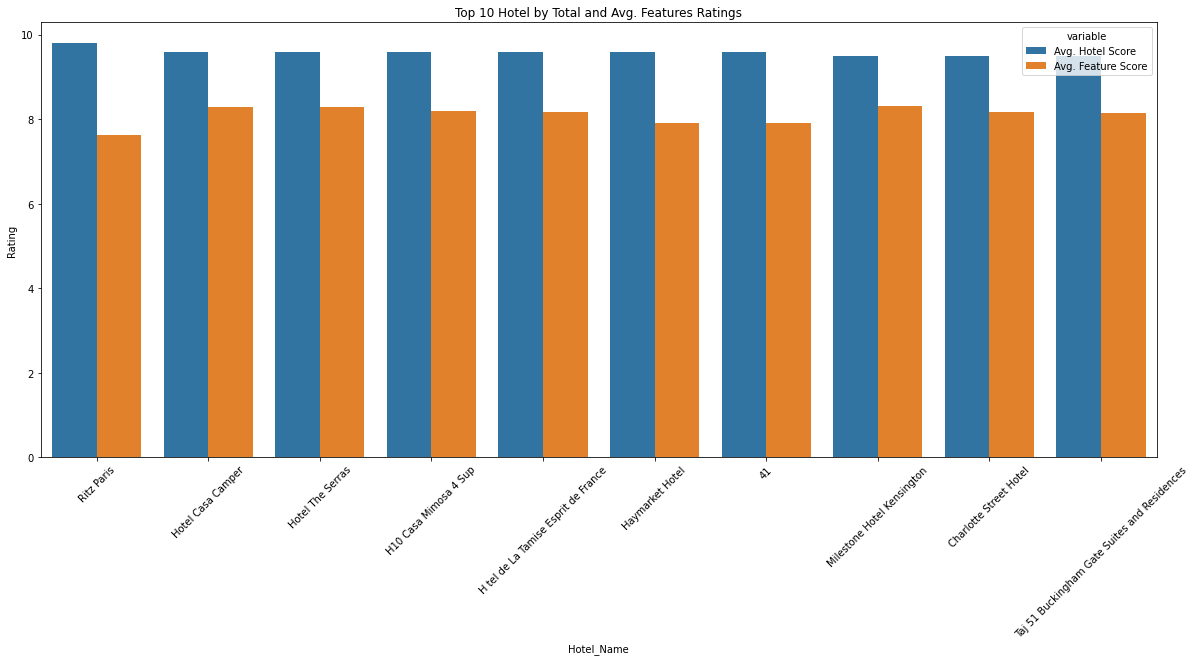

In [246]:
plt.figure(figsize=(20,8), num=None)
sns.barplot(y='value',
             x='Hotel_Name',
             hue='variable',
             data=top_hotels_agg)
plt.xticks(rotation=45)
plt.title('Top 10 Hotel by Total and Avg. Features Ratings')
plt.ylabel('Rating')
plt.show()

In [268]:
feature_dropdown = Dropdown(
    options= [(feature.capitalize(),'avg_'+ feature) for feature in ['room', 'hotel', 'breakfast', 'staff', 'bed', 'location']],
    value='avg_room',
    description='Feature:')

def update_plot(feature):
    plt.figure(figsize=(20,8), num=None)
    sns.barplot(x='Hotel_Name',
    y=feature,
    data=hotels.sort_values(feature,ascending=False).iloc[:10])
    plt.xticks(rotation=45)
    name = feature.split("_")[1].capitalize() + ' Feature'
    print(name)
    plt.title(f'Top 10 Hotel by {name}')
    plt.ylabel(name)

interactive(update_plot, feature=feature_dropdown)

interactive(children=(Dropdown(description='Feature:', options=(('Room', 'avg_room'), ('Hotel', 'avg_hotel'), …

## 6. Regress Average_Hotel_Score against the top five feature scores of each hotel, and provide quantitative estimates of how important each feature is for the Average_Hotel_Score. (2 points)

In [279]:
data = hotels.dropna()

features = ['room', 'hotel', 'breakfast', 'staff', 'bed', 'location']

X = data[['avg_'+ feature for feature in features]]
y = data['Average_Hotel_Score']

In [287]:
linear_reg = LinearRegression()

linear_reg.fit(X, y)

coefficients = dict(zip(features,linear_reg.coef_))

coefficients = {k:round(v,3) for k,v in sorted(coefficients.items(), key=lambda item: item[1],reverse=True)}
coefficients

{'hotel': 0.551,
 'room': 0.547,
 'staff': 0.189,
 'location': 0.025,
 'bed': 0.023,
 'breakfast': 0.014}

### Write clear, compact, and understandable code with comment/markdown statements as appropriate. Non-working code or unnecessary code will be penalized. (2 points)

Submit your Jupyter file using the link below.